In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from off_pol_eval_functions import * 
import sys
import numpy as np
import scipy
import scipy.stats
from scipy.spatial.distance import cdist
import csv
from sklearn import tree
from sklearn import linear_model, neighbors, ensemble, tree

from warfarin_functions import * 

ntrs = np.arange(100,2501,100)
runsper = 4
runsperper = 25
params = [ntr for ntr in ntrs for run in range(runsper)]

myid = 0#int(sys.argv[1])
# np.random.seed(myid)
ntr = 1000#params[myid-1]

f = open('warfrin.csv','rU')
csvr = csv.reader(f, dialect=csv.excel)
header = np.array(csvr.next())
data   = list(csvr)
f.close()

# filter only to subjects that reached stable dose of warfarin
# and stable observed INR
data = [x for x in data if x[37]=='1' and x[38]!='NA' and x[39]!='NA']

agegroups = sorted(set(x[8].replace('NA','') for x in data))

xmap = lambda x: \
[
    # gender 0
    ('Male?',x[3]=='male'),
    # race 1:4
    ('White?',x[5]=='White'),
    ('Asian?',x[5]=='Asian'),
    ('Black?',x[5]=='Black or African American'),
    # ethnicity 4
    ('Non-hispanic?',x[7]=='not Hispanic or Latino'),
    # age 5:7
    ('Age group',agegroups.index(x[8]) if x[8] in agegroups else 0),
    ('No age?',x[8] not in agegroups or agegroups.index(x[8]) == 0),
    # height 7
    ('Height',float(x[9]) if x[9] not in ('NA', '') else 0.),
        # x[9] in ('NA', ''), # NA indicator
    # weight 8
    ('Weight',float(x[10]) if x[10] not in ('NA', '') else 0.),
        # x[10] in ('NA', ''), # NA indicator
    # BMI
    ('BMI',float(x[10])*100.*100./float(x[9])/float(x[9]) if x[10] not in ('NA', '') and x[9] not in ('NA', '') else 0.),
] + [# Indication for Warfarin Treatment 9:17
    ('Indication for Warfarin Treatment: '+str(i), str(i) in x[11])
    for i in range(1,9)
# ] + [# comorbidities
#     c in (y.strip() for y in x[12].lower().split('; '))
#     for c in comorbidities
] + [# diabetes 17:19
    ('Diabetes=0?',x[13]=='0'),
    ('Diabetes=1?',x[13]=='1'),
] + [#Congestive Heart Failure and/or Cardiomyopathy 19:21
    ('Congestive Heart Failure and/or Cardiomyopathy=0?',x[14]=='0'),
    ('Congestive Heart Failure and/or Cardiomyopathy=1?',x[14]=='1'),
] + [#Valve Replacement 21:23
    ('Valve Replacement=0?',x[15]=='0'),
    ('Valve Replacement=1?',x[15]=='1'),
# ] + [# medications
#   x[16]
] + [
    # Aspirin 24:26
    ('aspirin=0?',x[17]=='0'),
    ('aspirin=1?',x[17]=='1'),
    # Acetaminophen or Paracetamol (Tylenol) 26:28
    ('Acetaminophen=0?',x[18]=='0'),
    ('Acetaminophen=1?',x[18]=='1'),
    # Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day 28:30
    ('Acetaminophen hi dose=0?',x[19]=='0'),
    ('Acetaminophen hi dose=1?',x[19]=='1'),
    # Simvastatin (Zocor) 30:32
    ('Simvastatin=0?',x[20]=='0'),
    ('Simvastatin=1?',x[20]=='1'),
    # Atorvastatin (Lipitor) 32:34
    ('Simvastatin=0?',x[21]=='0'),
    ('Simvastatin=1?',x[21]=='1'),
    # Fluvastatin (Lescol) 34:36
    ('Fluvastatin=0?',x[22]=='0'),
    ('Fluvastatin=1?',x[22]=='1'),
    # Lovastatin (Mevacor) 36:38
    ('Lovastatin=0?',x[23]=='0'),
    ('Lovastatin=1?',x[23]=='1'),
    # Pravastatin (Pravachol) 38:40
    ('Pravastatin=0?',x[24]=='0'),
    ('Pravastatin=1?',x[24]=='1'),
    # Rosuvastatin (Crestor) 40:42
    ('Rosuvastatin=0?',x[25]=='0'),
    ('Rosuvastatin=1?',x[25]=='1'),
    # Cerivastatin (Baycol) 42:43
    ('Cerivastatin=0?',x[26]=='0'),
    ('Cerivastatin=1?',x[26]=='1'),
    # Amiodarone (Cordarone)
    ('Amiodarone=0?',x[27]=='0'),
    ('Amiodarone=1?',x[27]=='1'),
    # Carbamazepine (Tegretol)
    ('Carbamazepine=0?',x[28]=='0'),
    ('Carbamazepine=1?',x[28]=='1'),
    # Phenytoin (Dilantin)
    ('Phenytoin=0?',x[29]=='0'),
    ('Phenytoin=1?',x[29]=='1'),
    # Rifampin or Rifampicin
    ('Rifampin=0?',x[30]=='0'),
    ('Rifampin=1?',x[30]=='1'),
    # Sulfonamide Antibiotics
    ('Sulfonamide Antibiotics=0?',x[31]=='0'),
    ('Sulfonamide Antibiotics=1?',x[31]=='1'),
    # Macrolide Antibiotics
    ('Macrolide Antibiotics=0?',x[32]=='0'),
    ('Macrolide Antibiotics=1?',x[32]=='1'),
    # Anti-fungal Azoles
    ('Anti-fungal Azoles=0?',x[33]=='0'),
    ('Anti-fungal Azoles=1?',x[33]=='1'),
    # Herbal Medications, Vitamins, Supplements
    ('Herbal Medications, Vitamins, Supplements=0?',x[34]=='0'),
    ('Herbal Medications, Vitamins, Supplements=1?',x[34]=='1'),
] + [
    #smoker
    ('Smoker=0?',x[40]=='0'),
    ('Smoker=0?',x[40]=='1'),
] + [
    # CYP2C9 consensus
    ('CYP2C9 *1/*1',x[59]=='*1/*1'),
    ('CYP2C9 *1/*2',x[59]=='*1/*2'),
    ('CYP2C9 *1/*3',x[59]=='*1/*3'),
    ('CYP2C9 NA',x[59]=='' or x[59]=='NA'),
    # VKORC1 -1639 consensus
    ('VKORC1 -1639 A/A',x[60]=='A/A'),
    ('VKORC1 -1639 A/G',x[60]=='A/G'),
    ('VKORC1 -1639 G/G',x[60]=='G/G'),
    # VKORC1 497 consensus
    ('VKORC1 497 T/T',x[61]=='T/T'),
    ('VKORC1 497 G/T',x[61]=='G/T'),
    ('VKORC1 497 G/G',x[61]=='G/G'),
    # VKORC1 1173 consensus
    ('VKORC1 1173 T/T',x[62]=='T/T'),
    ('VKORC1 1173 C/T',x[62]=='C/T'),
    ('VKORC1 1173 C/C',x[62]=='C/C'),
    # VKORC1 1542 consensus
    ('VKORC1 1542 C/C',x[63]=='C/C'),
    ('VKORC1 1542 C/G',x[63]=='C/G'),
    ('VKORC1 1542 G/G',x[63]=='G/G'),
    # VKORC1 3730 consensus
    ('VKORC1 3730 A/A',x[64]=='A/A'),
    ('VKORC1 3730 A/G',x[64]=='A/G'),
    ('VKORC1 3730 G/G',x[64]=='G/G'),
    # VKORC1 2255 consensus
    ('VKORC1 2255 C/C',x[65]=='C/C'),
    ('VKORC1 2255 C/T',x[65]=='C/T'),
    ('VKORC1 2255 T/T',x[65]=='T/T'),
    # VKORC1 -4451 consensus
    ('VKORC1 -4451 C/C',x[66]=='C/C'),
    ('VKORC1 -4451 A/C',x[66]=='A/C'),
    ('VKORC1 -4451 A/A',x[66]=='A/A')
#     ,
#     ('Therapeutic Dose',float(x[38]) if x[38] not in ('NA', '') else 0.),
#     ('INR On Therapeutic Dose',float(x[39]) if x[39] not in ('NA', '') else 0.),
#     ('Target INR', float(x[35]) if x[35] not in ('NA', '') else 0. )
]

X       = np.array([zip(*xmap(x))[1] for x in data])
Xnames  = np.array(zip(*xmap(data[0]))[0])
goodidx = np.where( (X.std(0)>=.05)  )[0] #np.sort(np.hstack((np.where(X.std(0)>=.05)[0],np.where(Xnames=='BMI')[0])))
X       = X[:,goodidx]
Xnames  = Xnames[goodidx]
# filter out by where BMI is nonzero 
goodbmi = np.where( (X[:,9] > 0.003) )[0]
X       = X[goodbmi,:]
# ytarget = np.array([float(x[38]) for x in data])/7.

target_INR = np.array([float(x[35]) if x[35] not in ('NA', '') else 0. for x in data])
therapeut_dose = np.array([float(x[38]) if x[38] not in ('NA', '') else 0. for x in data])
obs_INR = np.array([float(x[39]) if x[39] not in ('NA', '') else 0. for x in data])

target_INR = target_INR[goodbmi]; therapeut_dose = therapeut_dose[goodbmi]; obs_INR = obs_INR[goodbmi]

n = X.shape[0]
print n

3964


/home/trduong/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


International Normalised Ratio (INR) testing is well established as an integral part of warfarin treatment. INR has a critical role in maintaining the warfarin response within a therapeutic range, to provide the benefits of anticoagulation, while avoiding the risks of haemorrhage (Figure 1).

The INR is defined as

$$ INR =\left( \frac{\text{Patient Prothrombin Time (sec)}}{\text{Local Geometric Mean Prothrombin Time (sec)}}\right)^{ISI} $$

http://www.bpac.org.nz/BT/2010/November/inr.aspx

In most situations the INR target is 2.5 (target range 2.0 – 3.0). This range is appropriate for the prophylaxis or treatment of venous thromboembolism and reduction of the risk of systemic embolism for people with atrial fibrillation and valvular heart disease.5 In some situations higher ranges are more appropriate. The target INR may vary depending on individual clinical situations. The target INR for mechanical prosthetic valves is dependent on the type of valve replacement used.6



### Semi-simulated dosages

We can generate semi-simulated dosages from the true therapeutic dose by modeling dosage as a function of BMI and perturbing with some noise via a mixture model: 

$$T_i' = \mu_{T^*} + \sigma_{T^*} \sqrt{\theta} \frac{x_{BMI}- \mu_{BMI}}{\sigma_{BMI}} + \sqrt{(1 - \theta)} \sigma_{T^*} \epsilon$$

Suppose that the counterfactual outcome is given by a quadratic penalty to the INR outcome of the observed therapeutic dose: 

$$y_i' = y_i^* + \frac{(T_i' - T_i)^2sgn(T_i' - T_i)}{max(T_i^2, T_i'^2)}$$

This model also yields the propensity score for assigning the counterfactual dose. 
### Propensity score given our treatment generation model from BMI : 
   
where $\epsilon \sim N(0,1)$ and $Z_{BMI} = \frac{x_{BMI} - \mu_{BMI}}{\sigma_{BMI}}$

$$ \mathbb{P}[T_i'=t \mid x_{bmi} ] = \mathbb{P}\left[\epsilon = \frac{t - \mu_T^* - \sigma_T^* \sqrt{\theta}Z_{BMI}}{\sqrt{1 - \theta}} \right]$$


### Dosing policy evaluation and optimization 

In any observational dataset, we will not have access to the full counterfactual distribution of outcomes. Previous analysis of the Warfarin dataset has focused on predicting being in a discrete bin of the "correct" therapeutic dose, e.g. Hamsa Bastani, Bertsimas/Kallus introducing 0-1 loss for being in the same bin. Other work (Chen, Zeng, Kosorok) look at a direct model of the outcome and directly penalize 

We leverage the rich previous study of the impacts of warfarin dosing, treating these models and analyses as "oracle information" we use to simulate realistic outcome data. We consider previous studies analyzing the effect that different INR levels have on the odds ratios for complications including ischemic stroke and hemorrhagic complications. The intensity of anticoagulation induced by warfarin therapy trades off between decreased stroke prevention at low levels of INR (less effective anticoagulation), and increased risk of intracranial bleeding in over-anticoagulation regimes. Various factors such as patient age and pre-existing health conditions (previous stroke) affect patient risk in ways that have been previously studied, but we do not directly account for in this simulated study.

Proposed model: 

* Generate simulated doses as $T_i' = \mu_{T^*} + \sigma_{T^*} \sqrt{\theta} \frac{x_{BMI}- \mu_{BMI}}{\sigma_{BMI}} + \sqrt{(1 - \theta)} \sigma_{T^*} \epsilon$
* Simulate INR response to dose adjustment (inversion of dosage guidelines) <https://depts.washington.edu/anticoag/home/content/warfarin-maintenance-dosing-nomogram>: $\hat{y}(T_i')$
* Compute expected risk as a function of how the odds ratio is affected by INR [ACC/AHA/ESC 2006 guidelines for the management of patients with atrial fibrillation](https://academic.oup.com/europace/article/8/9/651/530495/ACC-AHA-ESC-2006-guidelines-for-the-management-of): $R(\hat{y}(T_i')$
* Compare $R(\hat{y}(\tau(X_i))$ across policies $\tau$


Optimization Question: 

If one generates a dataset of simulated dose adjustments and INR responses in this fashion, can you recover the therapeutic dose (or an optimal linear treatment policy which is similar) if you do off-policy optimization? What kind of treatment policy does the optimization return? 


In [4]:
def simulated_loss(sim_dose, therapeut_dose, obs_INR):
    return (np.abs(therapeut_dose - sim_dose))+ np.random.normal()*0.1*mu_dose

17.013676277413794
17.21068727968127
[36.44625628 39.76205743 30.56830155 ... 27.92877481 30.83598384
 18.31584311]


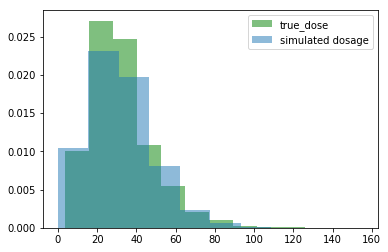

In [5]:
# Global values 
mu_dose = np.mean(therapeut_dose)
std_dose = np.std(therapeut_dose)
mu_bmi = np.mean(X[:,9])
std_bmi = np.std(X[:,9])

# regr = linear_model.LinearRegression()
# regr.fit(X[:,9].reshape([n,1]), therapeut_dose.reshape([n,1]))

theta = 0.5
eps = np.random.normal(size=n)

# eps = np.random.randn(n)
bmi_Z = (X[:,9] - mu_bmi)/std_bmi

# fit on centered model
regr = linear_model.LinearRegression(fit_intercept = False)
regr.fit(bmi_Z.reshape([n,1]), therapeut_dose.reshape([n,1]))


sim_dose = mu_dose  + (np.sqrt(theta)*bmi_Z*std_dose + np.sqrt(1-theta)*std_dose*eps) 
sim_dose[sim_dose < 0 ] = - sim_dose[sim_dose < 0 ] 
print np.std(sim_dose)
print std_dose 

plt.hist(therapeut_dose[therapeut_dose<150],alpha=0.5,color='g',label= 'true_dose', normed=True)
plt.hist(sim_dose,alpha = 0.5, label = "simulated dosage", normed=True)
plt.legend()

y_counter = np.asarray(simulated_loss(sim_dose, therapeut_dose, obs_INR))
print y_counter



## Propensity score given our treatment generation model from BMI : 
   
where $\epsilon \sim N(0,1)$ and $Z_{BMI} = \frac{x_{BMI} - \mu_{BMI}}{\sigma_{BMI}}$

$$ \mathbb{P}[T_i'=t \mid x_{bmi} ] = \mathbb{P}\left[\epsilon = \frac{t - \mu_T^* - \sigma_T^* \sqrt{\theta}Z_{BMI}}{\sqrt{1 - \theta}} \right]$$

In [7]:
# Add to param dictionary: 
# therapeutic dose ("oracle values") 
# observed INR  ("oracle values")
#! FIXME will require global access to therapeutic doses/ 
def generated_Q(bmi, T, theta, NULL): 
    # centeredaround mu_dose with scale stddev of dose
    theta = 0.5
    Z_bmi = (bmi-mu_bmi)/std_bmi
    return norm.pdf( T, loc = mu_dose + std_dose*np.sqrt(theta)*Z_bmi, scale = np.sqrt(1-theta) )

print generated_Q(30,40,0.9,std_dose)

d = 1
t_lo =0
t_hi = max(therapeut_dose)
data = { 'n': n, 'y': obs_INR,'Q': generated_Q, 'x': X[:,9],'x_samp':X[:,9],  'd': d, 'T': therapeut_dose,'t_lo': t_lo ,'t_hi': t_hi  }
data['tau'] = sim_dose
data['h'] = 3; data['n_bins'] = 10
data['kernel_int_func'] = epanechnikov_int
data['kernel_func'] = epanechnikov_kernel
data['oracle_func'] = counterfactual_y_eval
data['threshold'] = 0.01 
print np.mean(counterfactual_y_eval(**data))

print off_policy_evaluation(**data)


8.569864487260983e-07


NameError: name 'epanechnikov_int' is not defined

In [8]:
'''
Systematically evaluate over a treatment space defined by a linear treatment policy
'''
n_trials = 10
n_treatments = 10
t_lo = 0 ; t_hi = max(therapeut_dose) 
print t_hi / np.min(X[:,9])
beta_space = np.linspace(0.5,2, n_treatments)
off_pol_evals = np.zeros(n_treatments)
oracle_evals = np.zeros(n_treatments)
discrete_off_pol_evals = np.zeros(n_treatments)

def simulated_loss(sim_dose, therapeut_dose, obs_INR):
    return (np.abs(therapeut_dose - sim_dose))+ np.random.normal()*0.1*mu_dose


data['y'] = simulated_loss(sim_dose, therapeut_dose, obs_INR)
data['y_samp'] = simulated_loss(sim_dose, therapeut_dose, obs_INR)
data['T_samp'] = sim_dose 

# for beta_ind, beta in enumerate(beta_space):
#     tau = np.clip(beta*data['x'] , t_lo, t_hi).flatten()
#     data['tau'] = tau
#     oracle_evals[beta_ind] = np.mean(simulated_loss(tau, therapeut_dose, obs_INR))
#     off_pol_evals[beta_ind] = off_policy_evaluation(**data)
#     discrete_off_pol_evals[beta_ind] = off_pol_disc_evaluation(discretize_tau_policy , **data)



23.659662705000006


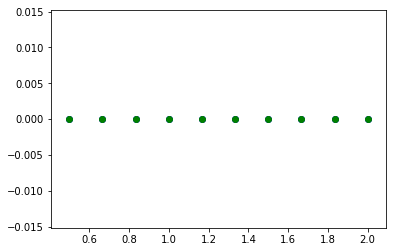

In [9]:
plt.scatter(beta_space, oracle_evals,color='b')
plt.scatter(beta_space, off_pol_evals,color='g')

## Train a more sophisticated model with more covariates

In [10]:
train_var = [5,9]+range(18,40)
subframe = X[:,[5,9]+range(18,40)]
subXnames = Xnames[[5,9]+range(18,40)]
# subframe = X 
# subXnames = Xnames
d = subframe.shape[1]
trainind = np.random.choice(range(n),size =  round(0.8*n),replace = False)
train = subframe[trainind]
test_mask = np.ones(n, dtype=bool)
test_mask[trainind] = False
test = subframe[test_mask,:]

y = simulated_loss(sim_dose[trainind], therapeut_dose[trainind], obs_INR[trainind])
def generated_Q_multid_X(x,t,t_lo,t_hi): 
    return generated_Q(x,t,t_lo,t_hi)


TypeError: 'float' object cannot be interpreted as an index

## Load full dataframe

In [11]:
y = simulated_loss(sim_dose[trainind], therapeut_dose[trainind], obs_INR[trainind])
h=4
d = X.shape[1]
train_data = { 'n': train.shape[0],'h': h, 'y': obs_INR,'Q': generated_Q_multid_X,'x_full': X, 'x': X,'x_samp': X[trainind,:],  'd': d, 'T': therapeut_dose[trainind],'t_lo': t_lo ,'t_hi': t_hi  }
train_data['kernel_int_func'] = epanechnikov_int
train_data['T_samp'] = np.array(sim_dose[trainind],order='F'); train_data['y_samp'] = np.array(simulated_loss(sim_dose[trainind], therapeut_dose[trainind], obs_INR[trainind]),order='F')
train_data['kernel_func'] = epanechnikov_kernel
train_data['DATA_TYPE'] = 'warfarin'
train_data['BMI_IND'] = 9
train_data['inds'] = trainind
train_data['threshold'] = 0.01

bounds = [(0, np.mean(therapeut_dose)/np.mean(X[:,i])) for i in range(d) ]
bnds = tuple(tuple(x) for x in bounds)

NameError: name 'trainind' is not defined

### load subframe data (temporary)

In [ ]:

y = simulated_loss(sim_dose[trainind], therapeut_dose[trainind], obs_INR[trainind])
d = subframe.shape[1]
train_data = { 'n': train.shape[0],'h': 4, 'y': obs_INR,'Q': generated_Q,'x_full': subframe, 'x': np.array(train,order='F'),'x_samp': np.array(train,order='F'), 'T_samp': sim_dose[trainind], 'd': d, 'T': therapeut_dose[trainind],'t_lo': t_lo ,'t_hi': t_hi  }
train_data['kernel_int_func'] = epanechnikov_int
train_data['T_samp'] = np.array(sim_dose[trainind],order='F'); train_data['y_samp'] = np.array(simulated_loss(sim_dose[trainind], therapeut_dose[trainind], obs_INR[trainind]),order='F')
train_data['kernel_func'] = epanechnikov_kernel
train_data['DATA_TYPE'] = 'warfarin'
train_data['BMI_IND'] = 1
train_data['inds'] = trainind
train_data['threshold'] = 0.01

bounds = [(0, np.mean(therapeut_dose)/np.mean(subframe[:,i])) for i in range(d) ]
bnds = tuple(tuple(x) for x in bounds)

In [ ]:
import pickle
t_lo = 0 
t_hi = max(therapeut_dose)

beta_d = np.random.rand(d)
h = 10
n_train = train.shape[0]
# train_data['oracle_func'] = counterfactual_y_eval

def pol_eval_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    data['tau'] = tau
    return off_policy_evaluation(**data)

def oracle_eval_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    return np.mean( simulated_loss(tau,therapeut_dose,obs_INR) )

# print off_pol_epan_lin_grad(beta_d, train_data)
LAMBDA = 0.4
def var_regularized_pol_eval_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    data['tau'] = tau
    return off_policy_evaluation(**data) + LAMBDA * np.linalg.norm(beta,2) + LAMBDA * off_policy_variance(**data)

def var_regularized_oracle_wrapper(beta, args): 
    data = dict(args)
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    return np.mean( simulated_loss(tau,therapeut_dose,obs_INR) )

def off_pol_var_lin_grad(beta, *args):
    """
    Compute a gradient for special case of Epanechnikov kernel and linear policy tau
    """
    
    d = len(beta) 
    params = dict(args[0]); n = params['n']
    THRESH = params['threshold']
    y_out = params['y']; x = params['x']; h = params['h'];Q = params['Q']; n = params['n']; t_lo = params['t_lo'];  t_hi = params['t_hi']
    kernel = params['kernel_func'];kernel_int =  params['kernel_int_func']
    y_out = params['y_samp']; T = params['T_samp']; x = params['x_samp']
 
    #! FIXME x vs xsamp
    tau = np.dot(beta, params['x'].T)
    params['tau'] = tau; params['beta'] = beta
    clip_tau = np.clip(tau, t_lo, t_hi)
    BMI_IND = params.get('BMI_IND'); THRESH = params['threshold'] # propensity score for warfarin data evaluations 
    

    [f, g, nabla_f, nabla_g] = f_g(**params)
    # compute gradient vector via quotient rule
    if g < THRESH: 
        g = THRESH  
    grad_estimator = np.asarray((g*nabla_f - f*nabla_g) / g**2 )
    var_grad = -1*f *grad_estimator
    var_grad_term1 = 0 
    for i in range(n): 
        if (params.get('DATA_TYPE') == 'warfarin'): 
            Q_i = Q(x[i,BMI_IND], T[i], t_lo, t_hi)
        else: 
            Q_i = Q(x[i], T[i], t_lo, t_hi)
        if (abs(clip_tau[i] - t_lo) <= h):
            alpha = kernel_int((t_lo-clip_tau[i])/h, 1)
        elif (abs(clip_tau[i] - t_hi) <= h):
            alpha = kernel_int(-1,  (t_hi - clip_tau[i])/h )
        else:
            alpha = 1
#         Qs[i] = kernel( (clip_tau[i] - T[i])/h )/max(Q_i,THRESH)
        if abs((clip_tau[i] - T[i])/h) >= 1:
            var_grad_term1 += 0 # don't add anything to partial derivatives 
        else:
            var_grad_term1 += 2* (kernel( (clip_tau[i] - T[i])/h )*1.0 * y_out[i]/max(Q_i,THRESH) * 1.0/alpha)*(.75*x[i]*y_out[i]/max(Q_i,THRESH)*(1 - 1.0*(clip_tau[i] - T[i])/h ))
    var_grad_term1 = var_grad_term1*1.0/n
    var_grad += var_grad_term1
    return np.asarray((g*nabla_f - f*nabla_g) / g**2 ) + 2*LAMBDA*beta + 2*var_grad 

def plot_training_set_hist(beta, x, therapeut_dose, sim_dose, title, policy_label): 
    plt.hist(np.abs(np.dot(beta, x.T)  - therapeut_dose ),range=[0,80],alpha = 0.5,label=policy_label)
    plt.hist(np.abs(sim_dose - therapeut_dose),alpha = 0.5,range=[0,80],color = 'g',label='original simulated dose' )
    plt.legend()
    plt.title(title,y=1.08)
    plt.ylabel('frequencies')
    plt.ylim((0, 1800))
    plt.xlabel('Absolute value of distance between recommended and therapeutic dose')
    plt.show()

In [ ]:
train_data['y'] = train_data['y']-np.mean(train_data['y'])
train_data['y_samp'] = train_data['y_samp']-np.mean(train_data['y_samp'])


In [ ]:
import datetime
d = X.shape[1]
n_restarts = 1
vals = np.zeros(n_restarts)
betas = [None]*n_restarts
i = 0 
while i <= n_restarts: 
    print i

    beta_d = 0.8*(mu_dose / (d*np.mean(X[trainind,:],axis=0))) +0.2*np.random.uniform(size=d,low=np.zeros(d), high = [bnds[k][1]*1.0/d for k in range(d) ])
    
#     beta_d = mu_dose / (d*np.mean(X[trainind,:],axis=0))
#     oracle_res = minimize(pol_eval_wrapper, x0 = beta_d, jac = off_pol_epan_lin_grad, bounds = bnds , options={'disp':True,'gtol':1e-4}, args=train_data.items())  
#     try: 
    oracle_res = minimize(var_regularized_pol_eval_wrapper, x0 = beta_d, bounds = bnds , options={'disp':True,'gtol':1e-3}, args=train_data.items())  

#         oracle_res = minimize(var_regularized_pol_eval_wrapper, x0 = beta_d, jac = off_pol_epan_lin_grad, bounds = bnds , options={'disp':True,'gtol':1e-4}, args=train_data.items())  
    betas[i] = oracle_res.x
    print oracle_res.x
    vals[i] = oracle_res.fun
    print oracle_res.fun
    i += 1
#     except: 
#         print "Gradient error"
    
pickle.dump(oracle_res.x, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'empirical_opt_beta-v2', 'wb'))
best_off_pol_beta = betas[np.argmin(vals)]
best_off_pol_val = vals[np.argmin(vals)]



In [ ]:
best_off_pol_beta

In [ ]:
# best_off_pol_beta = pickle.load(open('2017-05-16_23-32empirical_opt_beta-v2',"rb"))

plot_training_set_hist(best_off_pol_beta, X[trainind,:], therapeut_dose[trainind], sim_dose[trainind],"Comparison of empirically optimal treatment policy vs original dose","empirically optimal training policy")
plot_training_set_hist(best_off_pol_beta, X[test_mask,:], therapeut_dose[test_mask], sim_dose[test_mask],"Comparison of empirically optimal treatment policy vs original dose","empirically optimal training policy")

In [ ]:
import cvxpy as cvx
d = X.shape[1]
beta = cvx.Variable(d)
# Implement a thresholded loss
#cost = cvx.sum_entries(cvx.max_elemwise(cvx.abs(X[trainind,:]*beta - therapeut_dose[trainind]) - therapeut_dose[trainind]*0.1, 0))/n*1.0
# normal l1 loss (median regression)
cost = cvx.sum_entries(cvx.abs(X[trainind,:]*beta - therapeut_dose[trainind]))/n*1.0

constraints = [beta >= 0]
for i in range(d): 
    constraints += [beta[i] <= np.mean(therapeut_dose[trainind])/np.mean(X[trainind,i]) ]
prob = cvx.Problem(cvx.Minimize(cost), constraints)

prob.solve()
print beta.value
prescient_beta = beta.value.flatten().T
prescient_beta = np.ravel(prescient_beta).T

pickle.dump(prescient_beta, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'prescient-beta-v2', 'wb'))


In [ ]:
def oracle_eval_wrapper(beta, args): 
    data = dict(args)
    INDS = data['inds']
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x_samp'].T) , t_lo, t_hi).flatten()
    return np.mean( simulated_loss(tau,therapeut_dose[INDS],obs_INR[INDS]) )

beta_d = np.random.rand(d)
train_data['inds'] = trainind
oracle_actual_oracle_res = minimize(oracle_eval_wrapper, x0 = beta_d, bounds = bnds , options={'disp':True,'gtol':1e-4}, args=train_data.items())  
pickle.dump(oracle_actual_oracle_res.x, open('oracle_opt_beta', 'wb'))
print oracle_actual_oracle_res

In [ ]:
print oracle_actual_oracle_res
print "off pol oracle"
print oracle_res

## Build direct estimate and use 'regress and compare' 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_w_dose = np.column_stack((X, sim_dose))
X_w_dose.shape

clf = RandomForestRegressor(n_estimators=10)

clf = clf.fit(X[trainind,:],y=therapeut_dose[trainind])
train_data['x_full'] = X_w_dose
train_data['rf'] = clf

d = X.shape[1]
# Regression and compare 
# Iterate through dataset and choose dose maximizing dose response 

# n = len(trainind)
# ts = np.linspace(0,80,160)
# best_taus_for_x = np.zeros(n)
# for i in range(n): 
#     if (i%500 == 0): 
#         print i 
#     drf_vals = [clf.predict( np.append(X_w_dose[trainind[i],0:d-1], np.asarray(t)).reshape(1,-1)) for t in ts ]
#     best_tau = np.argmin(drf_vals)
#     best_taus_for_x[i] = ts[best_tau]
    


In [ ]:
Xnames

In [ ]:
d=X.shape[1]
sort_inds = np.argsort(clf.feature_importances_)[::-1][:d]

pickle.dump(sort_inds, open('important_features_fm_regr.p','wb'))
print Xnames[sort_inds[0:25]]

In [ ]:
pickle.dump(best_taus_for_x, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'dm_best_treatments-RC-train.p', 'wb'))
pickle.dump(best_taus_for_x_test, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'dm_best_treatments-RC-test.p', 'wb'))


In [ ]:
best_taus_for_x = pickle.load(open('2017-05-16_15-41dm_best_treatments-RC-train.p'))
best_taus_for_x_test = pickle.load(open('2017-05-16_15-41dm_best_treatments-RC-test.p'))

## Optimizing direct method 

In [ ]:
bounds = [ (0, np.mean(therapeut_dose)/(np.sqrt(d)*np.mean(X_w_dose[:,i]))) for i in range(d) ]
bnds = tuple(tuple(x) for x in bounds)
def dm_wrapper(beta, args): 
    data = dict(args)
    INDS = data['inds']
    t_lo = data['t_lo']; t_hi = data['t_hi']
    clf = train_data['rf']
    tau = np.clip(np.dot(beta, data['x_full'][trainind,:].T), t_lo, t_hi).flatten()
    counterfactual_X = np.column_stack((data['x_full'][trainind,0:d-1], tau))
    reg_lambda = 3
    return 100* (np.mean( clf.predict( counterfactual_X )) + reg_lambda * np.linalg.norm( beta, 1 )) 



beta_d = np.random.uniform(low = np.zeros(d), high = [bnds[i][1] for i in range(d) ], size = d)
epsilon = np.ones(d)*1e-2
dm_res = minimize(dm_wrapper, x0 = beta_d, jac= None, bounds = bnds , options={'disp':True,'gtol':1e-8, 'eps':np.ones(d)*1e-1}, args=train_data.items())  

pickle.dump(dm_res.x, open(str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + 'dm_beta-v2', 'wb'))


In [ ]:
np.dot(dm_res.x, X_w_dose[trainind,:].T)

print dm_res.x
print len(dm_res.x[0:len(dm_res.x)-1])
print Xnames[np.where(dm_res.x[0:len(dm_res.x)-2] > 0)[0]]

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg

list_data = [ subframe[trainind,i] for i in range(d) ] + [sim_dose[trainind]]
print list_data
print len(list_data)
print [len(list_data[i]) for i in range(len(list_data))]
kernel_regr = KernelReg(endog = [y.reshape([len(trainind),1])], exog=list_data, var_type=['c']*len(list_data) )

In [ ]:
import pandas as pd 
df = pd.DataFrame(np.hstack([subframe[trainind], sim_dose[trainind].reshape([len(trainind),1])]) )

df.to_csv("train_data.csv", header = list(subXnames)+["sim_dose"],index=None)
ydf = pd.DataFrame(y) 
ydf.to_csv('y.csv',header='y',index =None)

## Discrete off-policy evaluation and optimization 

In [ ]:
def discretize_dose(dose): 
    discretized_dose = np.zeros(len(dose))
    for i in range(len(dose)): 
        if dose[i] < 21: 
            discretized_dose[i] = 0 
        elif dose[i] < 49: 
            discretized_dose[i] = 1
        elif dose[i] >= 49: 
            discretized_dose[i] = 2
    return discretized_dose

disc_therapeutic_dose = discretize_dose(therapeut_dose)
disc_sim_dose = discretize_dose(sim_dose) 

def generated_Q_wrapper(T, bmi, theta, NULL): 
    theta = 0.5
    # centeredaround mu_dose with scale stddev of dose
    Z_bmi = (bmi-mu_bmi)/std_bmi
    return norm.pdf( T, loc = mu_dose + std_dose*np.sqrt(theta)*Z_bmi, scale = np.sqrt(1-theta) )

min_T = min(sim_dose)
max_T = max(sim_dose)
# y is still the same loss information ( distance from treatment ) 
def integrated_gps(bmi, T, min_T, max_T ): 
    theta = 0.5
    GPS = np.zeros(len(T))
    for i in range(len(T)): 
        if T[i] < 21: 
            GPS[i] = scipy.integrate.quad( generated_Q_wrapper, 5, 21, args=(bmi[i], theta, theta) )[0]
        elif T[i] < 49: 
            GPS[i] = scipy.integrate.quad( generated_Q_wrapper, 21, 49, args=(bmi[i], theta, theta) )[0]
        elif T[i] >= 49: 
            GPS[i] = scipy.integrate.quad( generated_Q_wrapper, 49, 80, args=(bmi[i], theta, theta) )[0]
    if i % 500 == 0: 
        print i 
    return GPS

integrated_propensity_scores = integrated_gps(X[trainind,9], sim_dose[trainind], min_T, max_T)

In [ ]:
------

In [ ]:
# Impute POEM 
import sys
sys.path.append('./POEM-norm/')
import DatasetReader, Skylines

Xtrain = X[trainind,:]
ttrain = disc_sim_dose.astype(int)[trainind]
gps = np.asarray([generated_Q_wrapper(sim_dose[i], X[trainind,9][i], 0.5, 0.5 ) for i in range(len(trainind))])
# all 0-1
# gps = integrated_propensity_scores
ytrain = y
Xtest = X[test_mask,:]



mydata = DatasetReader.BanditDataset(None,False)
mydata.trainFeatures        = np.hstack((Xtrain.copy(),np.ones((len(Xtrain),1))))
mydata.sampledLabels        = np.zeros((len(ttrain),max(ttrain)+1))
mydata.sampledLabels[range(len(ttrain)),ttrain] = 1.
mydata.trainLabels          = np.empty(mydata.sampledLabels.shape)
mydata.sampledLoss          = ytrain.copy()
mydata.sampledLoss         -= mydata.sampledLoss.min()
mydata.sampledLoss         /= mydata.sampledLoss.max()
# computed on training set 
mydata.sampledLogPropensity = np.log(gps)
#ones_like vs ones_line? 
mydata.testFeatures              = np.hstack((np.ones_like(Xtest),np.ones((len(Xtest),1))))
mydata.testLabels                = np.array([])
mydata.createTrainValidateSplit(validateFrac = 0.25)
pool = None 
coef = None

maj = Skylines.PRMWrapper(mydata, n_iter = 1000, tol = 1e-6, minC = 0, maxC = -1, minV = 0, maxV = -1,
                            minClip = 0, maxClip = 0, estimator_type = 'Vanilla', verbose = True,
                            parallel = pool, smartStart = coef)
maj.calibrateHyperParams()
maj.validate()
Xtest1 = np.hstack((Xtest,np.ones((len(Xtest),1))))
rec = Xtest1.dot(maj.labeler.coef_).argmax(1)



In [ ]:
rec

In [ ]:
### POEM-norm

mydata = DatasetReader.BanditDataset(None,False)
mydata.trainFeatures        = np.hstack((Xtrain.copy(),np.ones((len(Xtrain),1))))
mydata.sampledLabels        = np.zeros((len(ttrain),max(ttrain)+1))
mydata.sampledLabels[range(len(ttrain)),ttrain] = 1.
mydata.trainLabels          = np.empty(mydata.sampledLabels.shape)
mydata.sampledLoss          = ytrain.copy()
mydata.sampledLoss         -= mydata.sampledLoss.min()
mydata.sampledLoss         /= mydata.sampledLoss.max()
mydata.sampledLogPropensity = np.log(gps)
mydata.testFeatures              = np.hstack((np.ones_like(Xtest),np.ones((len(Xtest),1))))
mydata.testLabels                = np.array([])
mydata.createTrainValidateSplit(validateFrac = 0.25)
pool = None 
coef = None

maj = Skylines.PRMWrapper(mydata, n_iter = 1000, tol = 1e-6, minC = 0, maxC = -1, minV = 0, maxV = -1,
                            minClip = 0, maxClip = 0, estimator_type = 'SelfNormal', verbose = True,
                            parallel = pool, smartStart = coef)
maj.calibrateHyperParams()
maj.validate()
Xtest1 = np.hstack((Xtest,np.ones((len(Xtest),1))))
rec = Xtest1.dot(maj.labeler.coef_).argmax(1)

In [ ]:
rec

In [ ]:
from sklearn.linear_model import LogisticRegression

imputed_Q = LogisticRegression(multi_class = "multinomial",solver='lbfgs')
# Impute probability of low/medium/high simulated dose
imputed_Q.fit(subframe[trainind], disc_sim_dose[trainind])

recentered_loss = discretized_loss - np.mean(discretized_loss)

In [ ]:
def off_pol_disc_given_disc_evaluation(policy, **params):
    THRESH = 0.000001
    y_out = params['y']; x = params['x_samp']; h = params['h']; Q = params['Q']; n = params['n']; t_lo = params['t_lo']; t_hi = params['t_hi']
    imputed_Q = params['imputed_Q']
    if ('y_samp' in params.keys()):
        y_out = params['y_samp'].flatten()
    if ('T_samp' in params.keys()):
        T = params['T_samp'].flatten()
    else:
        T = params['T'].flatten()

    t_lo = min(T)
    t_hi = max(T)
    
    T_binned = discretize_dose(T)
    bins = range(unique(T_binned)) + 1
    bin_means = [T[T_binned == i].mean() for i in range(1, len(bins))]
    tau_bins = discretize_dose(params['tau'])
    loss = 0
    treatment_overlap = np.where(np.equal(tau_bins, T_binned))[0]

    for ind in treatment_overlap:
        # use a discrete probability 
        loss += y_out[ind]/max(Q_i,THRESH)
    n_overlap = len(treatment_overlap)
    if n_overlap == 0:
        print "no overlap"
        return np.inf
    return loss/(1.0*n_overlap)


def oracle_eval_wrapper(beta, args): 
    data = dict(args)
    INDS = data['inds']
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    return np.mean( simulated_loss(tau,therapeut_dose[INDS],obs_INR[INDS]) )


beta_d = np.random.rand(d)
train_data['inds'] = trainind
oracle_actual_oracle_res = minimize(oracle_eval_wrapper, x0 = beta_d, bounds = bnds , options={'disp':True,'gtol':1e-4}, args=train_data.items())  
pickle.dump(oracle_actual_oracle_res.x, open('oracle_opt_beta', 'wb'))
print oracle_actual_oracle_res

## Histograms of performance

### hist results of giving mu_dose amount of treatment

In [ ]:

plt.hist(np.abs(np.mean(sim_dose[trainind]) - therapeut_dose[trainind] ).T,range=[0,80],alpha = 0.5,label='best-in-class treatment policy')
plt.hist(np.abs(sim_dose[trainind] - therapeut_dose[trainind]),range=[0,80],alpha = 0.5,color = 'g',label='original simulated dose' )
plt.title("Histogram of training set performance of assigning mean of simulated dose",y=1.08)
plt.legend()
plt.ylabel('frequencies')
plt.ylim((0,1800))
plt.xlabel('Absolute value of distance between recommended and therapeutic dose')
plt.show()

plt.hist(np.abs(np.mean(sim_dose[test_mask]) - therapeut_dose[test_mask] ).T,range=[0,80],alpha = 0.5,label='best-in-class treatment policy')
plt.hist(np.abs(sim_dose[test_mask] - therapeut_dose[test_mask]),range=[0,80],alpha = 0.5,color = 'g',label='original simulated dose' )
plt.title("Histogram of training set performance of assigning mean of simulated dose",y=1.08)
plt.legend()
plt.ylabel('frequencies')
plt.ylim((0,1800))
plt.xlabel('Absolute value of distance between recommended and therapeutic dose')
plt.show()

In [ ]:

plt.hist(np.abs(np.asarray((train*prescient_beta).flatten()) - therapeut_dose[trainind] ).T,range=[0,80],alpha = 0.5,label='best-in-class treatment policy')
plt.hist(np.abs(sim_dose[trainind] - therapeut_dose[trainind]),range=[0,80],alpha = 0.5,color = 'g',label='original simulated dose' )
plt.title("Histogram of training set performance of best-in-class treatment policy",y=1.08)
plt.legend()
plt.ylabel('frequencies')
plt.ylim((0,1800))
plt.xlabel('L1 deviation from 10% range of therapeutic dose')
plt.show()

In [ ]:
np.ravel(prescient_beta).T

## histogram results of off-policy evaluation

In [ ]:
plot_training_set_hist(best_off_pol_beta, X[trainind,:], therapeut_dose[trainind], sim_dose[trainind], "Training set performance of empirically optimal treatment policy")

print "test set performance"
plot_training_set_hist(best_off_pol_beta, X[test_mask,:], therapeut_dose[test_mask], sim_dose[test_mask], "Test set performance of empirically optimal treatment policy")

In [ ]:
plot_training_set_hist(prescient_beta, X[trainind,:], therapeut_dose[trainind], sim_dose[trainind], 'Training set performance of best-in-class treatment policy')

print "test set performance"
plot_training_set_hist(prescient_beta, X[test_mask,:], therapeut_dose[test_mask], sim_dose[test_mask], 'Test set performance of best-in-class treatment policy')

In [ ]:
print sum(np.abs(sim_dose[trainind] - therapeut_dose[trainind]))
print sum(np.abs(np.dot(oracle_actual_oracle_res.x, train.T) - therapeut_dose[trainind]))
print sum(np.abs(np.dot(oracle_res.x, train.T) - therapeut_dose[trainind]))

In [ ]:
np.asarray((np.dot(best_off_pol_beta, train.T) - sim_dose[trainind]))

In [ ]:
np.dot(best_off_pol_beta, train.T)

plt.hist(np.abs(np.dot(best_off_pol_beta, train.T)  - therapeut_dose[trainind] ),range=[0,80],alpha = 0.5,label='empirically optimal treatment policy')
plt.hist(np.abs(sim_dose[trainind] - therapeut_dose[trainind]),alpha = 0.5,range=[0,80],color = 'g',label='original simulated dose' )
plt.legend()
plt.title('Histogram of training set performance of empirically optimal treatment policy',y=1.08)
plt.ylabel('frequencies')
plt.ylim((0, 1800))
plt.xlabel('L1 deviation from 10% range of therapeutic dose')
plt.show()


In [ ]:
print test.shape
plt.hist(np.abs(np.dot(oracle_actual_oracle_res.x, test.T) - therapeut_dose[test_mask]),range=[0,50],alpha = 0.7,color='r', label='best-in-class treatment policy')
plt.hist(np.abs(np.dot(oracle_res.x, test.T) - therapeut_dose[test_mask]),range=[0,50],alpha = 0.7,color='g', label='empirically optimal treatment policy')
plt.hist(np.abs(sim_dose[test_mask] - therapeut_dose[test_mask]),range=[0,50],alpha = 0.5, color = 'b' ,label = 'original simulated dose')
plt.title("Histogram of out-of-sample test performance (deviation from therapeutic dose)",y=1.08)
plt.legend(loc='upper right')
plt.ylabel('frequency')
plt.xlabel('L1 deviation from 10% range of therapeutic dose')
plt.show()

## Direct method regress and compare 

In [ ]:
plot_training_set_hist(dm_res.x, X_w_dose[trainind,:], therapeut_dose[trainind], sim_dose[trainind], 'Test set performance of direct method (random forest) policy optimization', 'random forest policy')
plot_training_set_hist(dm_res.x, X_w_dose[test_mask,:], therapeut_dose[test_mask], sim_dose[test_mask], 'Test set performance of direct method (random forest) policy optimization', 'random forest policy')



In [ ]:
ts = np.linspace(0,80,160)
n_test = sum(test_mask)
best_taus_for_x_test = np.zeros(n_test)
for i in range(n_test): 

    drf_vals = [clf.predict( np.append(X_w_dose[test_mask,:][i,0:d-1], np.asarray(t)).reshape(1,-1)) for t in ts ]
    best_tau = np.argmin(drf_vals)
    best_taus_for_x_test[i] = ts[best_tau]
    
    if (i%100 == 0): 
        print i 
        plt.plot(ts, drf_vals)
    
print best_taus_for_x_test

In [ ]:

plt.figure()
i=100
drf_vals = [clf.predict( np.append(X_w_dose[test_mask][i,0:d-1], np.asarray(t)).reshape(1,-1)) for t in ts ]
plt.plot(ts,drf_vals)
print ts[np.argmin(drf_vals)]
plt.figure()

i = 100 
drf_vals = [clf.predict( np.append(X_w_dose[test_mask[i],0:d-1], np.asarray(t)).reshape(1,-1)) for t in ts ]
plt.plot(ts,drf_vals)

print ts[np.argmin(drf_vals)]

## Off policy evaluation regress \& compare 

In [ ]:
ts = np.linspace(0,80,160)
n_test = sum(test_mask)
best_taus_for_x_test = np.zeros(n_test)
for i in range(n_test): 
    drf_vals = [clf.predict( np.append(X_w_dose[test_mask,:][i,0:d-1], np.asarray(t)).reshape(1,-1)) for t in ts ]
    best_tau = np.argmin(drf_vals)
    best_taus_for_x_test[i] = ts[best_tau]
    
    if (i%100 == 0): 
        print i 
        plt.plot(ts, drf_vals)
    
print best_taus_for_x_test

In [ ]:
print np.median(np.abs(sim_dose[test_mask] - therapeut_dose[test_mask]))
print np.median(np.abs(np.dot(oracle_actual_oracle_res.x, test.T) - therapeut_dose[test_mask]))
print np.median(np.abs(np.dot(oracle_res.x, test.T) - therapeut_dose[test_mask]))

## boxplot of results 

In [ ]:
print(plt.style.available)

plt.style.use('seaborn-notebook')

In [ ]:
%matplotlib inline
plt.style.use('seaborn-white')
plt.figure()


# prescient_norm = np.abs(np.dot(prescient_beta, X[test_mask,:].T)  - therapeut_dose[test_mask] )
# off_pol_norm = np.abs(np.dot(best_off_pol_beta, X[test_mask,:].T)  - therapeut_dose[test_mask] )
# mean_dose_pol_norm = np.abs(np.mean(sim_dose[test_mask]) - therapeut_dose[test_mask] )
# dm_norms = np.abs(np.dot(dm_res.x, X_w_dose[test_mask,:].T)  - therapeut_dose[test_mask] )
# original = np.abs(sim_dose[test_mask] - therapeut_dose[test_mask])

prescient_norm =(np.dot(prescient_beta, X[test_mask,:].T)  - therapeut_dose[test_mask] )
off_pol_norm = (np.dot(best_off_pol_beta, X[test_mask,:].T)  - therapeut_dose[test_mask] )
mean_dose_pol_norm = (np.mean(sim_dose[test_mask]) - therapeut_dose[test_mask] )
dm_norms = (best_taus_for_x_test  - therapeut_dose[test_mask] )
original = (sim_dose[test_mask] - therapeut_dose[test_mask])


norms = [prescient_norm, off_pol_norm, dm_norms, mean_dose_pol_norm, original]

plt.figure(figsize=(4.5,3))
plt.ylabel('Differences btn. policy and therapeutic dose')
flierprops = dict(linestyle='-',color='black')

# prefer to turn off mean line
bp_dict = plt.boxplot(norms,sym='', showmeans = False, meanline=False)

for whisker in bp_dict['whiskers']:
    whisker.set(color='#000000',linestyle='solid')
for box in bp_dict['boxes']:
    # change outline color
    box.set( color='#000000')
for ind,line in enumerate(bp_dict['medians']):
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    if ind == 4: 
        plt.text(x-0.18, y+4, '%.1f' % y, horizontalalignment='center') # draw above, centered
    # overlay median value
    else:
        plt.text(x+0.2, y+4, '%.1f' % y, horizontalalignment='center') # draw above, centered

top = 60
bottom = -60
plt.ylim(bottom, top)
# plt.title('Boxplot of distances between policy-recommended doses and therapeutic doses',y = 1.2)
plt.axhline(y=np.median(mean_dose_pol_norm), xmin=0,xmax=1,color='g', ls='dashdot',linewidth=0.7)
plt.axhline(y=0, xmin=0,xmax=1,color='g',alpha=0.3, ls='dashed',linewidth=0.7)
plt.xticks([1, 2, 3,4,5], ['Best-In-Class', 'Continuous OPE', 'DM (Random Forest R&C)', 'Mean dose', 'Original doses'])
plt.xticks(rotation=25)
plt.show()

plt.violinplot(norms)



In [ ]:
best_off_pol_beta


In [ ]:
print "medians"
print np.median(prescient_norm)
print np.median(off_pol_norm )
print np.median(mean_dose_pol_norm )
print np.median(dm_norms)
print np.median(original)

print "means"
print_f_(np.mean)

def print_f_(func): 
    print func(prescient_norm)
    print func(off_pol_norm )
    print func(mean_dose_pol_norm )
    print func(dm_norms)
    print func(original)
               
               
print "sum of absolute values of differences"
print_f_(lambda x: sum(abs(x)))
print "standard deviations "
print_f_(np.std)

In [ ]:
off_pol_dose_test = np.dot(best_off_pol_beta, X[test_mask,:].T
plt.scatter(X[test_mask][:,9], best_taus_for_x_test,color='r',alpha=0.3,label='treatment dose from DM')
plt.scatter(X[test_mask][:,9], np.dot(best_off_pol_beta, X[test_mask,:].T),color='g',alpha=0.3 , label='treatment dose from OPE')
plt.scatter(X[test_mask][:,9], therapeut_dose[test_mask],color='b',alpha=0.1 , label='therapeutic dose')


plt.xlabel("BMI")
plt.ylabel('dose')
plt.legend()

# Doubly Robust estimator from DM, IPW 

In [ ]:
from copy import deepcopy 
def DR_wrapper(beta, args): 
    data = dict(args)
    INDS = data['inds']
    t_lo = data['t_lo']; t_hi = data['t_hi']
    clf = train_data['rf']
    # train beta which gets best treatment policy for direct estimator 
    tau = np.clip(np.dot(beta, data['x'][INDS,:].T), t_lo, t_hi).flatten()
    # concatenate 1st (d) colunns of full X 
    counterfactual_X = np.column_stack((data['x_full'][INDS,0:-1], tau))
    reg_lambda = 3
    data = dict(args)
    # evaluate rhat(\tau_i, x_i) 
    dm = np.mean( clf.predict( counterfactual_X ))
    t_lo = data['t_lo']; t_hi = data['t_hi']
    tau = np.clip(np.dot(beta, data['x'].T) , t_lo, t_hi).flatten()
    data['tau'] = tau
    
    # evaluate rhat(t_i, x_i) on observed treatments
    T_X = np.column_stack((data['x_full'][INDS,0:-1], sim_dose[INDS]))
    old_y = data_copy['y_samp']
    data['y_samp'] = data['y_samp'] - clf.predict( T_X )
    ipw = off_policy_evaluation(**data)
    data['y_samp'] = old_y 
    
    return 100*(dm + ipw) 

d = X.shape[1]
beta_d = np.random.rand(d)
train_data['inds'] = trainind

bounds = [(0, np.mean(therapeut_dose)/(np.sqrt(d)*np.mean(X_w_dose[:,i]))) for i in range(d) ]
bnds = tuple(tuple(x) for x in bounds)

oracle_DR_res = minimize(DR_wrapper, x0 = beta_d, bounds = bnds , options={'disp':True,'gtol':1e-3}, args=train_data.items())  
pickle.dump(DR_wrapper.x, open('oracle_DR_beta', 'wb'))
print oracle_DR_res